# Problem 4

In [396]:
# requirements
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

In [397]:
# dataset 4
np.random.seed(1234)
n = 200
x_d4 = 3 * (np.random.rand(n, 4) - 0.5)
y_d4 = (2 * x_d4[:, 0] - 1 * x_d4[:,1] + 0.5 + 0.5 * np.random.randn(n)) > 0
y_d4 = 2 * y_d4 - 1

In [398]:
# CVXOPT Implementation
def solve_l1_hinge_cvxopt(X, y, lam):
    n, d = X.shape

    # Variable definitions
    w = cv.Variable(d)
    xi = cv.Variable(n)  # Slack variables for hinge loss
    e = cv.Variable(d)   # Auxiliary variables for L1 regularization

    # Objective function
    objective = cv.Minimize(cv.sum(xi) + lam * cv.sum(e))

    # Constraints
    constraints = [
        # Hinge loss constraints: ξi ≥ 1 − yi*w^T*xi
        xi >= 1 - cv.multiply(y, X @ w),
        # Non-negative slack variables: ξi ≥ 0
        xi >= 0,
        # L1 regularization linearization: ej ≥ wj
        e >= w,
        # L1 regularization linearization: ej ≥ -wj
        e >= -w
    ]

    # Problem definition and solving
    prob = cv.Problem(objective, constraints)
    prob.solve(solver=cv.CVXOPT)  # Use CVXOPT solver

    if prob.status != cv.OPTIMAL:
        print(f"Warning: Optimization did not converge. Status: {prob.status}")

    return w.value, prob.value

# Execute CVXOPT method
results_cvxopt = {}
w_opt_cvxopt, obj_val_cvxopt = solve_l1_hinge_cvxopt(x_d4, y_d4, lam=0.001)

In [399]:
# Proximal Subgradient Method Implementation
def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def hinge_loss_subgradient(X, y, w):
    margins = y * (X @ w)
    violated = margins < 1

    # Subgradient computation
    subgrad = np.zeros_like(w)
    for i in range(len(y)):
        if violated[i]:
            subgrad -= y[i] * X[i]

    return subgrad / len(y)

def proximal_subgradient_l1_hinge(X, y, lam, max_iter=3000, initial_lr=1, tol=1e-8):
    n, d = X.shape
    w = np.zeros(d) # Initialize

    obj_history = []
    w_history = []

    for t in range(max_iter):
        # Objective function value computation
        margins = y * (X @ w)
        hinge_losses = np.maximum(0, 1 - margins)
        obj_val = np.mean(hinge_losses) + lam * np.sum(np.abs(w))

        obj_history.append(obj_val)
        w_history.append(w.copy())
        lr = initial_lr / np.sqrt(1 + t)

        # Hinge loss subgradient
        subgrad_hinge = hinge_loss_subgradient(X, y, w)

        # Gradient step
        w_new = w - lr * subgrad_hinge

        # Proximal operator (L1 regularization)
        w = soft_thresholding(w_new, lr * lam)

        # Convergence check
        if t > 0 and abs(obj_history[-2] - obj_history[-1]) < tol:
            break

    return w, obj_history, w_history

# Execute proximal subgradient method
results_proxgrad = {}
w_opt, obj_hist, w_hist = proximal_subgradient_l1_hinge(
    x_d4, y_d4, lam=0.001, max_iter=3000, initial_lr=1
)


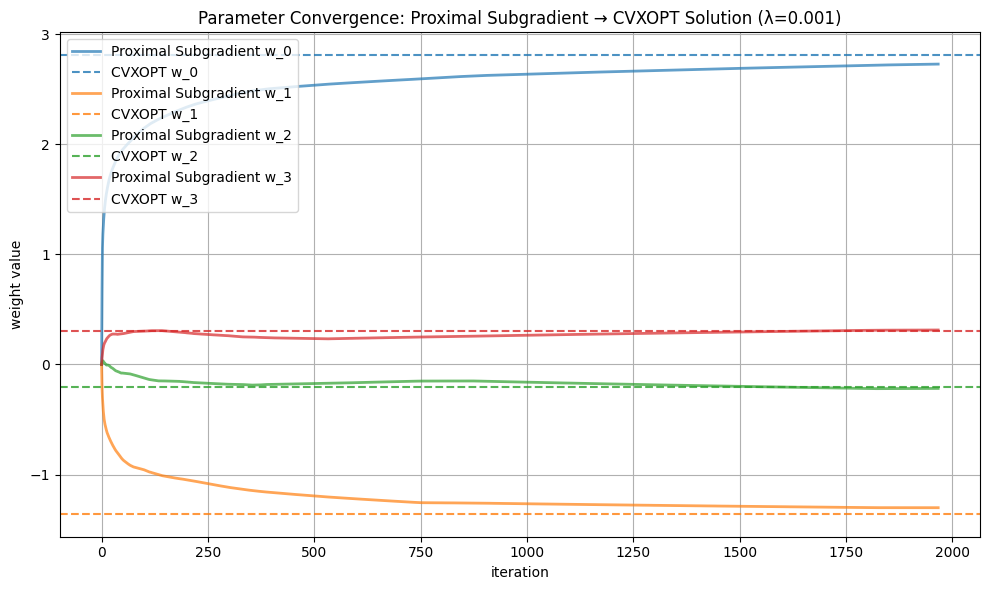

In [400]:
# Parameter convergence visualization
w_hist = np.array(w_hist)

plt.figure(figsize=(10, 6))

for i in range(w_hist.shape[1]):
    plt.plot(w_hist[:, i], label=f'Proximal Subgradient w_{i}', alpha=0.7, linewidth=2)
    # Add CVXOPT solution as horizontal dashed line
    plt.axhline(y=w_opt_cvxopt[i], color=f'C{i}', linestyle='--', alpha=0.8, 
                label=f'CVXOPT w_{i}')

plt.xlabel('iteration')
plt.ylabel('weight value')
plt.title('Parameter Convergence: Proximal Subgradient → CVXOPT Solution (λ=0.001)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()